In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from HS_reading import *


In [2]:
clean_data_path = "D:/BaiduSyncdisk/code"
clear_path = "D:/BaiduSyncdisk/code/"
# clean_data_path = "/Users/zhaozehao/Desktop/reading task"
# clear_path = "/Users/zhaozehao/Desktop/reading task/"


In [3]:
from scipy.ndimage import gaussian_filter1d
from tqdm import trange
def get_task_ecog(HS,clean_data_path,sigma):
    file_name = "HS" + str(HS) + "_Block_overt_covert.mat"
    z3 = scio.loadmat(os.path.join(clean_data_path+"/HSblockdata", file_name))
    HSblock = z3["Alldata"][0][0]
    if HS < 70:
        task_list = ["overt","covert"]
        sound_list = ["ba", "bu", "da", "du", "ga", "gu"]

    else:
        task_list = ["overt","covert","cue"]
        sound_list = ["ba", "da", "ga", "pa", "ta", "ka", "sa", "sha"]

    HS_avg_ECoG = {}
    Ecog_title = "ECoG_"
    for task in task_list:
        HS_avg_ECoG[task] = HSblock[Ecog_title+task+"_"+sound_list[0]]
        for sound_index in range(1,len(sound_list)):
            HS_avg_ECoG[task] = np.concatenate((HS_avg_ECoG[task],HSblock[Ecog_title+task+"_"+sound_list[sound_index]]),axis=0) 
        HS_avg_ECoG[task] = np.mean(HS_avg_ECoG[task],axis=0)
        for j in trange(HS_avg_ECoG[task].shape[0],desc=task):
            HS_avg_ECoG[task][j] = gaussian_filter1d(HS_avg_ECoG[task][j],sigma)
    return HS_avg_ECoG


In [4]:
HS = 45
ecog_data_3 = get_task_ecog(HS,clean_data_path,sigma = 3)
ecog_data_6 = get_task_ecog(HS,clean_data_path,sigma = 6)

covert: 100%|██████████| 256/256 [00:00<00:00, 64004.64it/s]


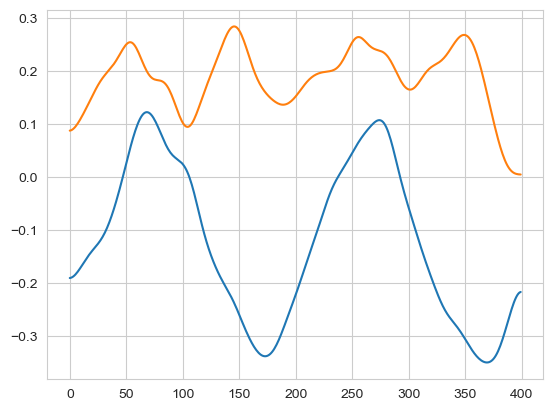

In [21]:
plt.plot(ecog_data_6["overt"][22])
plt.plot(ecog_data_6["covert"][28])

In [44]:

import matplotlib.image as mpimg
import scipy.io as scio
import os
import cv2

def generate_img_video(ecog_data,clean_data_path,start_time,end_time,task = "overt",fig_size = (10,10),f=10,kde_plot=True):

    images = []
    path = clean_data_path
    path_save = path + "/img_video"
    subject = 'HS'+str(HS)
    img = mpimg.imread(path +"/elecs/Brain2D/"+ subject + "_brain2D.png")
    xy = scio.loadmat(path +"/elecs/Brain2D/"+ subject + "_elec_pos2D.mat")['elecmatrix']
    n_chans = 256 if xy.shape[0] >= 256 else 128
    
    all_sig_elecs =np.load(path +"/elecs/elec_sig/"+str(HS)+"sig_elecs.npy",allow_pickle=True).item()
    for time in trange(start_time,end_time,desc=f'{task}'):
        fig, ax = plt.subplots(figsize=fig_size)
        ax.imshow(img)
        z = plt.get_cmap("coolwarm")
        plt.title("HS_"+str(HS)+": "+task+" "+str(time))

        
        if kde_plot == True:
            index_positive = np.where(ecog_data[task][all_sig_elecs[task]][:,time]>0)
            
            index_negative = np.where(ecog_data[task][all_sig_elecs[task]][:,time]<0)

            if len(index_negative[0])>1:
                xdata = pd.DataFrame({"x":xy[all_sig_elecs[task],0][index_negative[0]],"y": xy[all_sig_elecs[task],1][index_negative[0]]})

                sns.kdeplot(xdata,x="x", y="y",cmap="Blues", fill=True, shade_lowest=False, alpha=0.5)

            if len(index_positive[0])>1:
                
                xdata = pd.DataFrame({"x":xy[all_sig_elecs[task],0][index_positive[0]],"y": xy[all_sig_elecs[task],1][index_positive[0]]})

                sns.kdeplot(xdata,x="x", y="y",cmap="Reds", fill=True, shade_lowest=False, alpha=0.5)
        else:
            for i in range(n_chans):
                if i in all_sig_elecs[task]:
                        #对皮尔森相似度正的为红色，负的为蓝色,不显著的为绿色, 不显著的电极为灰色
                    ax.plot(xy[i][0], xy[i][1], 'o',color = z(ecog_data[task][i][time]),alpha = 0.7)
        ax.grid('off') 
        ax.box(None)
        plt.xticks([])
        plt.yticks([])
        
        fig.savefig(path_save+f'/HS{HS}_{task}_fig{time}.png')
        plt.close(fig)
    # 将图像添加到图像列表中
        images.append(path_save+f'/HS{HS}_{task}_fig{time}.png')
    video_size = (100*fig_size[0],100*fig_size[1])
    video = cv2.VideoWriter(path_save+f'/HS{HS}_{task}.avi',cv2.VideoWriter_fourcc(*'MJPG'),f,video_size)

    for i in range(len(images)):
        #读取图片
        img = cv2.imread(images[i])     
        # resize方法是cv2库提供的更改像素大小的方法
        # 写入视频
        video.write(img)
    # 释放资源
    video.release()
    
    for i in range(len(images)):
        #读取图片
        os.remove(images[i])     

    return images

In [ ]:
HS = 45
ecog_data_3 = get_task_ecog(HS,clean_data_path,3)#3 means the sigma of gauss

In [46]:
task_list = ['overt','covert']
for task in task_list:
    generate_img_video(ecog_data_3,clean_data_path,start_time=110,end_time=200,f=10,task=task,fig_size=(20,20))




overt:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\960814332.py:32: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(xdata,x="x", y="y",cmap="Blues", shade=True, shade_lowest=False, alpha=0.5)
C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\960814332.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(xdata,x="x", y="y",cmap="Blues", shade=True, shade_lowest=False, alpha=0.5)
C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\960814332.py:38: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(xdata,x="x", y="y",cmap="Reds", shade=True, shade_lowest=False, alpha=0.5)
C:\Users\DELL\AppData\Loc

C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\3589612820.py:14: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(np.array([xy[all_sig_elecs[task],0][index_negative[0]], xy[all_sig_elecs[task],1][index_negative[0]]]).T,
C:\Users\DELL\AppData\Local\Temp\ipykernel_6776\3589612820.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.array([xy[all_sig_elecs[task],0][index_negative[0]], xy[all_sig_elecs[task],1][index_negative[0]]]).T,


AttributeError: 'Patch' object has no property 'cmap'

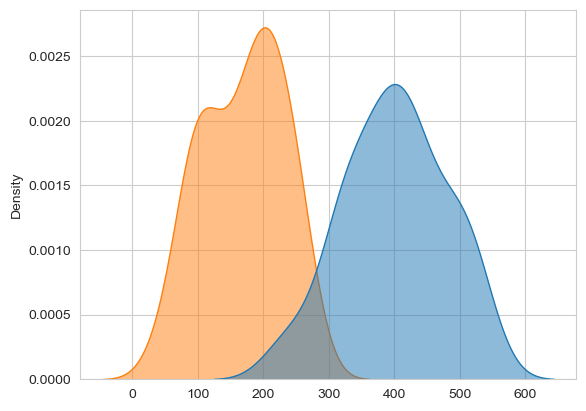

In [30]:
# path = clean_data_path
# path_save = path + "/img_video"
# subject = 'HS'+str(HS)
# img = mpimg.imread(path +"/elecs/Brain2D/"+ subject + "_brain2D.png")
# xy = scio.loadmat(path +"/elecs/Brain2D/"+ subject + "_elec_pos2D.mat")['elecmatrix']
# n_chans = 256 if xy.shape[0] >= 256 else 128
# 
# all_sig_elecs =np.load(path +"/elecs/elec_sig/"+str(HS)+"sig_elecs.npy",allow_pickle=True).item()
# 
# task = "overt"
# 
# index_negative = np.where(ecog_data_3["overt"][all_sig_elecs['overt']][:,100]<0)
# if len(index_negative[0])>1:
#     sns.kdeplot(np.array([xy[all_sig_elecs[task],0][index_negative[0]], xy[all_sig_elecs[task],1][index_negative[0]]]).T,
#               cmap="Blues", shade=True, shade_lowest=False, alpha=0.5)

In [25]:
# xy[all_sig_elecs[task],0][index_negative[0]]

array([447.07330811, 445.82911423, 444.44349305, 424.91186566,
       425.25788686, 425.03695775, 420.1908367 , 418.59913765,
       402.74609785, 403.10525086, 403.02249419, 380.95037834,
       381.00389927, 380.31564968, 378.32984448, 377.15019334,
       375.75476681, 530.19678376, 516.35140963, 513.94830593,
       511.56028022, 511.36190784, 499.24386742, 481.2347535 ,
       479.34624088, 335.55610338, 332.88741309, 330.80393714,
       321.41319651, 329.05850832, 324.7006242 , 305.75166729,
       307.02482495, 239.96856982, 238.52799502])